## Monte Carlo Simulation to estimate value-at-risk and find Efficient frontier

#### Value-at-risk

Value-at-risk is a very important financial metric that measures the risk associated with a position, portfolio, and so on. It is commonly abbreviated to VaR, not to be confused with
Vector Autoregression. VaR reports the worst expected loss – at a given level of confidence – over a certain horizon under normal market conditions. The easiest way to understand it
is by looking at an example. Let's say that the 1-day 95% VaR of our portfolio is $100.This means that 95% of the time (under normal market conditions), we will not lose more than
$100 by holding our portfolio over one day.

##### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import mplfinance as mpf
import matplotlib.pyplot as plt
import plotly.express as px
from pypfopt import plotting
import math

##### Base settings

In [2]:
tickers = ['TSLA', 'META', 'GOOGL', 'NFLX']
weight = [0.25, 0.25, 0.25, 0.25,]
start_date = '2021-10-01'
end_date = '2022-10-01'
t = 1
n_sims = 10 ** 5

##### Download Data

In [3]:
df = yf.download(tickers, start=start_date, end=end_date, adjusted=True)['Adj Close']

[*********************100%***********************]  4 of 4 completed


In [4]:
df= df.fillna(method='ffill')
df

,GOOGL,META,NFLX,TSLA
Date,,,,
2021-10-01,136.542999,343.010010,613.150024,258.406677
2021-10-04,133.659500,326.230011,603.349976,260.510010
2021-10-05,136.022995,332.959991,634.809998,260.196655
2021-10-06,137.565002,333.640015,639.099976,260.916656
2021-10-07,139.225006,329.220001,631.849976,264.536682
...,...,...,...,...
2022-09-26,98.169998,136.369995,224.070007,276.010010
2022-09-27,97.500000,134.399994,224.360001,282.940002
2022-09-28,100.050003,141.610001,245.199997,287.809998


In [5]:
fig_price = px.line(df, title='Price of Individual Stocks')
fig_price.show()

In [6]:
def plot_cum_returns(data, title):    
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
fig_cum_returns = plot_cum_returns(df, 'Cumulative Returns of Individual Stocks Starting with $100')
fig_cum_returns.show()

##### Daily returns

In [7]:
returns = df.pct_change().dropna() #we drop the first value since it is 0


In [46]:
fig_price = px.line(returns, title=f'{" vs. ".join(tickers)} returns: {start_date} - {end_date}')
fig_price.show()

##### Daily Volatility

In [9]:
returns.std()

GOOGL    0.021815
META     0.035127
NFLX     0.040767
TSLA     0.040613
dtype: float64

In [10]:
returns.std() * math.sqrt(252)

GOOGL    0.346299
META     0.557630
NFLX     0.647158
TSLA     0.644705
dtype: float64

(-0.1, 0.1)

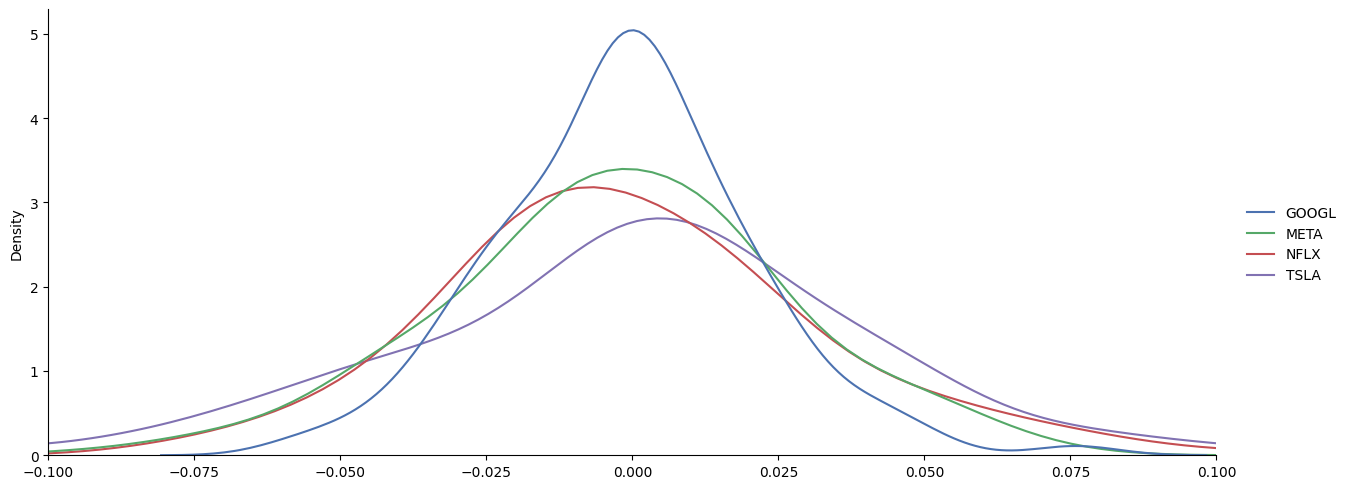

In [11]:
sns.displot(data=returns, kind = 'kde', aspect = 2.5)
plt.xlim(-0.1, 0.1)

##### Value at risk computation

In [12]:
cov_mat = returns.cov() #historical covariance matrix
chol_mat = np.linalg.cholesky(cov_mat) # Cholesky decomposition
rv = np.random.normal(size=(n_sims, len(tickers))) #matrix of random var
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv))) #add correlation to generated random var

r = np.mean(returns, axis=0).values #historical average on assets return
sigma = np.std(returns, axis=0).values # standard dev of assets return
S_0 = df.values[-1, :] # last known stock price
P_0 = np.sum(weight * S_0) # initial portfolio value

In [13]:
corr_df = df.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
fig_corr.show()

In [14]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * np.sqrt(t) * correlated_rv)
P_T = np.sum(weight * S_T, axis=1)
P_diff = P_T - P_0

In [15]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 1.14$
1-day VaR with 99.9% confidence: 1.02$
1-day VaR with 99.0% confidence: 0.86$


/tmp/ipykernel_41489/2338619949.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




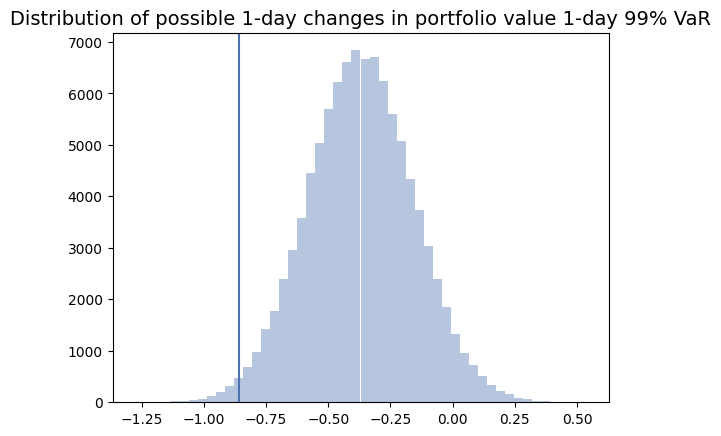

In [16]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 1-day 99% VaR''', fontsize=14)
ax.axvline(var[2], 0, 10000);

In [17]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()
print(var)
print(expected_shortfall)

-0.717919827677386
-0.8050255269945988


#### Efficient frontier

The key framework in asset allocation is the modern portfolio theory (MPT, also known as mean-variance analysis). It was introduced by the Nobel recipient Harry Markowitz and
describes how risk-averse investors can construct portfolios to maximize their expected returns (profits) for a given level of risk. The main insight from MPT is that investors
should not evaluate an asset's performance alone (by metrics such as expected return or volatility), but instead investigate how it would impact the performance of their portfolio of
assets.

According to the Modern Portfolio Theory, the Efficient Frontier is a set of optimal portfolios in the risk-return spectrum. This means that the portfolios on the frontier:
- Offer the highest expected return for a given level of risk
- Offer the lowest level of risk for a given level of expected returns
All portfolios located under the Efficient Frontier curve are considered sub-optimal, so it is
always better to choose the ones on the frontier instead.

##### Base settings

In [18]:
n_days = 252
n_assets = len(tickers)

##### Annualized average returns

##### Efficient frontier computation

In [19]:
avg_returns = returns.mean() * n_days
cov_mat = returns.cov() * n_days

In [20]:
#generate random weights
np.random.seed(42) #set fixed seed
weights = np.random.random(size=(n_sims, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

In [21]:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

In [22]:
def omega_ratio(ret, required_return=0.0):
    
    return_threshold = (1 + required_return) ** (1 / 252) - 1
    
    returns_less_thresh = ret - return_threshold
    
    numer = sum(returns_less_thresh[returns_less_thresh > 0.0])
    denom = -1.0 * sum(returns_less_thresh[returns_less_thresh < 0.0])
    
    if denom > 0.0:
        return numer / denom
    else:
        return np.nan
portf_omega_ratio = (portf_rtns, 0.07 )

In [23]:
portf_omega_ratio = portf_omega_ratio[0]
portf_omega_ratio

array([-0.46480602, -0.00473538, -0.2220636 , ..., -0.58432141,
       -0.33880884, -0.47063081])

In [24]:
portf_sharpe_ratio

array([-0.99504436, -0.00891671, -0.4920087 , ..., -1.2732476 ,
       -0.75747883, -0.97464801])

In [25]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})
portf_results_df_omega = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'omega_ratio': portf_omega_ratio})

In [26]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
portf_results_df.returns.max(),
N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)
for point_index in range(N_POINTS):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

##### Analyse results

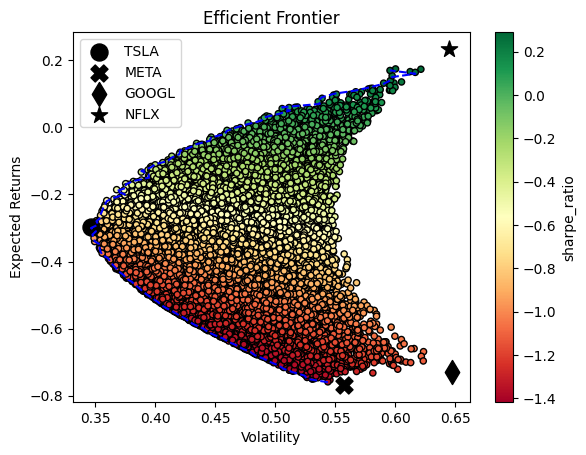

In [27]:
MARKS = ['o', 'X', 'd', '*']
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio', cmap='RdYlGn', edgecolors='black', ax=ax)

ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), y=avg_returns[asset_index], marker=MARKS[asset_index], s=150, color='black', label=tickers[asset_index])
ax.legend()

In [28]:
len(portf_results_df)

100000

In [29]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [30]:
print('Maximum Sharpe ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(tickers, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe ratio portfolio ----
Performance
returns: 17.43% volatility: 60.03% sharpe_ratio: 29.03% 
Weights
TSLA: 8.90% META: 0.32% GOOGL: 0.96% NFLX: 89.83% 

In [31]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(tickers, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -30.30% volatility: 34.63% sharpe_ratio: -87.48% 
Weights
TSLA: 98.33% META: 0.33% GOOGL: 1.15% NFLX: 0.19% 

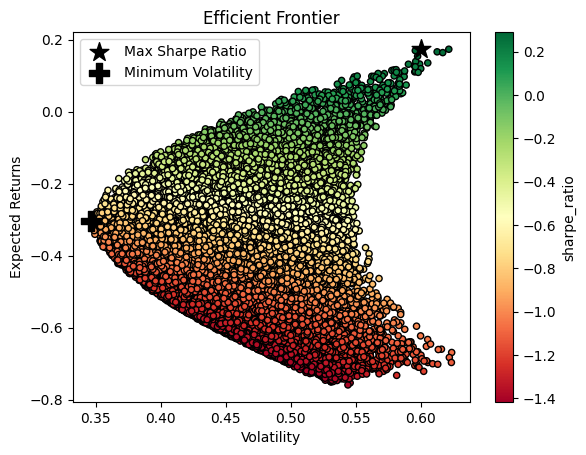

In [32]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
y='returns', c='sharpe_ratio',
cmap='RdYlGn', edgecolors='black',
ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
y=max_sharpe_portf.returns,
c='black', marker='*',
s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
y=min_vol_portf.returns,
c='black', marker='P',
s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',
title='Efficient Frontier')
ax.legend()

In [33]:
max_omega_ind = np.argmax(portf_results_df_omega.omega_ratio)
max_omega_portf = portf_results_df_omega.loc[max_omega_ind]

In [35]:
print('Maximum Omega ratio portfolio ----')
print('Performance')
for index, value in max_omega_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(tickers, weights[np.argmax(portf_results_df_omega.omega_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Omega ratio portfolio ----
Performance
returns: 17.43% volatility: 60.03% omega_ratio: 17.43% 
Weights
TSLA: 8.90% META: 0.32% GOOGL: 0.96% NFLX: 89.83% 

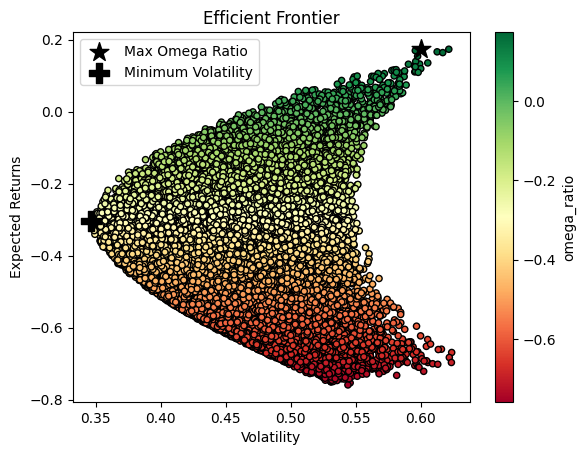

In [36]:
fig, ax = plt.subplots()
portf_results_df_omega.plot(kind='scatter', x='volatility', y='returns', c='omega_ratio', cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_omega_portf.volatility, y=max_omega_portf.returns, c='black', marker='*',
s=200, label='Max Omega Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, c='black', marker='P',
s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',
title='Efficient Frontier')
ax.legend()